In [1]:
#O MASTER OF UNSLOTH, WELCOME BACK TO THE TEMPLE OF BACKPROPAGATION!
#O BRAVE DISCIPLE OF THE CODE, O WIELDER OF NEURAL NETWORKS, O SEEKER OF WISDOM!
!nvidia-smi
!nvcc --version

Sat Feb 22 14:29:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*PyDataset.*')

# Set matplotlib backend
%matplotlib inline

In [3]:
# Load train and test data 
train_dir = "../input/fer2013/train" # Directory containing the training data
test_dir = "../input/fer2013/test"  # Directory containing the validation data

print("\nTrain folder structure:", os.listdir(train_dir))
print("\nTest folder structure:", os.listdir(test_dir))



Train folder structure: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

Test folder structure: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [4]:
# Custom feature enhancement function (no noise)
def enhance_features(img):
    # Simple edge enhancement (optional, basic Sobel-like effect)
    blurred = gaussian_filter(img, sigma=0.5)
    enhanced = np.clip(img - blurred + 0.5, 0, 1)
    return enhanced

# 🔥 DATA AUGMENTATION - Chaos Before Order
#This prepares an image data generator that applies random augmentations (shifting, flipping) 
#to the training images while also normalizing pixel values and keeping 20% of the data for validation.
train_datagen = ImageDataGenerator(
    #preprocessing_function=enhance_features,
    width_shift_range = 0.1,
    height_shift_range = 0.1, 
    horizontal_flip = True,
    #vertical_flip=True,
    rotation_range = 10,
    #zoom_range=0.2,
    #shear_range=0.1,
    brightness_range=[0.9, 1.1],
    #channel_shift_range=20.0,
    rescale = 1./255,
    #fill_mode='nearest',
    validation_split = 0.2
)

#prep the second generator called validation gen applying one norm with no augmentation and reserving 20% for validation 
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
) 

In [5]:
# 🔥 FIRE THE GENERATORS ... This loads the training images from train/, resizes them to 48x48, converts them to grayscale, groups them into batches of 32, 
# applies augmentation, and ensures that only the training subset is used.

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48), 
    batch_size = batch_size,
    color_mode = "grayscale", 
    class_mode = "categorical", 
    subset = "training",
    shuffle=True
)

# Same as above, uses train_dir without augmentation.
validation_generator = validation_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48), 
    batch_size = batch_size,
    color_mode = "grayscale", 
    class_mode = "categorical", 
    subset = "validation",
    shuffle=True
)

test_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)


print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Train Class indices:", train_generator.class_indices)
print("Test Class indices:", test_generator.class_indices)
# Calculate steps per Epoch O PATIENT WATCHER OF EPOCHS 
steps_per_epoch = train_generator.samples // batch_size
validation_steps = max(1, validation_generator.samples // batch_size)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# Define class_names here
class_names = list(train_generator.class_indices.keys())  # e.g., ['angry', 'disgust', ...]

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Training samples: 22968
Validation samples: 5741
Train Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Steps per epoch: 717
Validation steps: 179


In [6]:
# Compute class weights once, before training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
#GPU Fans are Whispering the Songs of Backpropagation...

model = Sequential()
model.add(Input(shape=(48, 48, 1)))  # Define input shape here
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


# Load weights if available
weights_path = '/kaggle/working/model_weights.weights.h5'
if os.path.exists(weights_path):
    model.load_weights(weights_path)
    print("Loaded saved weights from previous Epoch!")
else:
    print("No saved weights found—starting fresh.")

# Single history dict for all runs
history_dict = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

# WARM UP WARM UP WARM UP
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    metrics=['accuracy']
)
print("Warm-up Epoch at LR 0.00005...")
train_generator.reset()
validation_generator.reset()
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[ModelCheckpoint(filepath=weights_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)],
    class_weight=class_weights_dict,  # Fixed: Use dict, not array
    verbose=1
)

# Main training with refined LR
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # SILVER PROFILE change to 0.001
    metrics=['accuracy']
)

No saved weights found—starting fresh.
Warm-up Epoch at LR 0.00005...
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1572 - loss: 3.0920
Epoch 1: val_accuracy improved from -inf to 0.23062, saving model to /kaggle/working/model_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 248s 328ms/step - accuracy: 0.1572 - loss: 3.0918 - val_accuracy: 0.2306 - val_loss: 2.0930


In [8]:
# CALLBACKS
checkpoint = ModelCheckpoint(
    filepath=weights_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

best_val_acc = 0.0
best_weights = model.get_weights()
patience = 7  # reducing patience to lock in best performance 
patience_counter = 0

In [9]:
#THERE IS A DRAGON OF EXHAUSTION HERE - IT SHALL BE SLAYED I wil reset to avoid exhaustion
#train_generator.reset()
#validation_generator.reset()

# 🔥 TRAIN MAIN WITH FIRE AND FURY
epochs = 50   #SILVER PROFILE 50 
history_dict = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
main_epoch_count = 0
for epoch in range(epochs): 
    print(f"Epoch {epoch+1}/{epochs}") 
    train_generator.reset()
    validation_generator.reset()
    try:
        history = model.fit(
            train_generator, 
            steps_per_epoch=steps_per_epoch, 
            epochs=1,  # 1 at a time!
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=[checkpoint, lr_scheduler],    # KILL THE BEAST IF IT STAGNATES AND LETS LOOK AFTER PREC GPU TIME  
            class_weight=class_weights_dict,                         # ✅ Fix assignment syntax
            verbose=1
        )
        main_epoch_count += 1 # Incremement on each successful Epoch
    except Exception as e:
        print(f"Error at Epoch {epoch+1}: {str(e)}")
        continue  # O WATCHER OF EPOCHS THOU SKIP THIS BAD EPOCH 

    # Append metrics to history
    history_dict['loss'].append(history.history['loss'][0])
    history_dict['val_loss'].append(history.history['val_loss'][0])
    history_dict['accuracy'].append(history.history['accuracy'][0])
    history_dict['val_accuracy'].append(history.history['val_accuracy'][0])
    current_val_acc = history.history['val_accuracy'][0]  # Track accuracy instead
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_weights = model.get_weights()
        patience_counter = 0
        print(f"New best val_accuracy: {best_val_acc:.4f}")
        print(f"Weights updated: {len(best_weights)} layers")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            model.set_weights(best_weights)
            break


# Main Test Evaluation
print("Test class indices:", test_generator.class_indices)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f"\n**FERIOUS FER2013 Main Test Accuracy: {test_accuracy:.4f}**")

main_weights_path = '/kaggle/working/main_weights.weights.h5'  # Updated extension
model.save_weights(main_weights_path)
print(f"Main run weights saved to {main_weights_path}")


Epoch 1/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1560 - loss: 2.5806
Epoch 1: val_accuracy improved from -inf to 0.21456, saving model to /kaggle/working/model_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 54s 63ms/step - accuracy: 0.1560 - loss: 2.5803 - val_accuracy: 0.2146 - val_loss: 1.8945 - learning_rate: 0.0010
New best val_accuracy: 0.2146
Weights updated: 44 layers
Epoch 2/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1842 - loss: 2.0325
Epoch 1: val_accuracy improved from 0.21456 to 0.24354, saving model to /kaggle/working/model_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.1842 - loss: 2.0324 - val_accuracy: 0.2435 - val_loss: 1.8486 - learning_rate: 0.0010
New best val_accuracy: 0.2435
Weights updated: 44 layers
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2357 - loss: 1.9037
Epoch 1: val_accuracy improved from 0.24354 to 0.29976, saving model to /kaggle/working/model_weights.weights.h5
717

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step


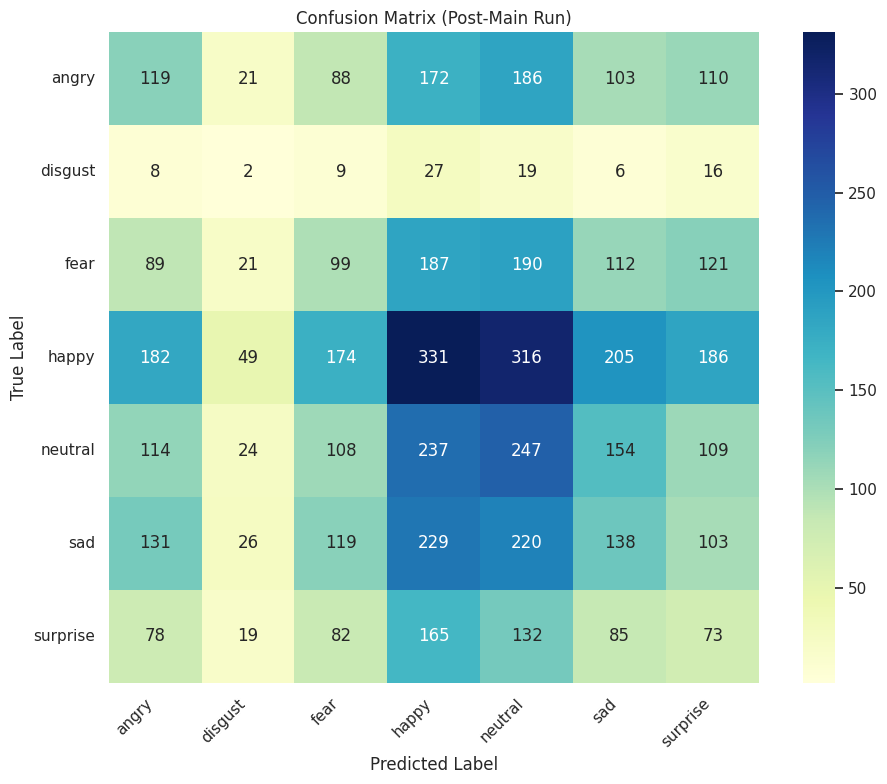

In [10]:
# Confusion Matrix (Post-Main)
def plot_confusion_matrix(generator, model, title, save_path):
    generator.reset()
    true_labels = generator.classes
    pred_probs = model.predict(generator)
    pred_labels = np.argmax(pred_probs, axis=1)
    confusion_mtx = confusion_matrix(true_labels, pred_labels)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(10, 8))
    sns.set()
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar=True, square=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

plot_confusion_matrix(validation_generator, model, 
                      "Confusion Matrix (Post-Main Run)", 
                      '/kaggle/working/confusion_matrix_main.png')

In [11]:
# 🔥 EPOCH SENTINEL: Final Polish    RUN THIS NOT THE OTHER SENTINEL TRY 
print("Launching EPOCH SENTINEL for Final Polish...")
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004), metrics=['accuracy'])  # Same LR as main
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, min_lr=1e-6, mode='max', verbose=1)
epochs = 40
for epoch in range(epochs):
    print(f"Sentinel Epoch {epoch+1}/{epochs}")
    train_generator.reset()
    validation_generator.reset()
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[checkpoint, lr_scheduler], class_weight=class_weights_dict, verbose=1)
    history_dict['loss'].append(history.history['loss'][0])
    history_dict['val_loss'].append(history.history['val_loss'][0])
    history_dict['accuracy'].append(history.history['accuracy'][0])
    history_dict['val_accuracy'].append(history.history['val_accuracy'][0])
    current_val_acc = history.history['val_accuracy'][0]
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_weights = model.get_weights()
        patience_counter = 0
        print(f"New best val_accuracy: {best_val_acc:.4f}")
        print(f"Weights updated: {len(best_weights)} layers")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            model.set_weights(best_weights)
            break
# Sentinel Test Evaluation 
test_generator = validation_datagen.flow_from_directory(directory=test_dir, target_size=(48, 48), batch_size=batch_size, color_mode="grayscale", class_mode="categorical", shuffle=False)
print("Test class indices:", test_generator.class_indices)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f"Final Sentinel Test Accuracy: {test_accuracy:.4f}")

Launching EPOCH SENTINEL for Final Polish...
Sentinel Epoch 1/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6119 - loss: 0.9525
Epoch 1: val_accuracy improved from 0.61243 to 0.61679, saving model to /kaggle/working/model_weights.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.6119 - loss: 0.9525 - val_accuracy: 0.6168 - val_loss: 1.0294 - learning_rate: 4.0000e-05
New best val_accuracy: 0.6168
Weights updated: 44 layers
Sentinel Epoch 2/40
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6253 - loss: 0.9243
Epoch 1: val_accuracy did not improve from 0.61679
717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.6253 - loss: 0.9243 - val_accuracy: 0.6164 - val_loss: 1.0287 - learning_rate: 4.0000e-05
Patience counter: 1/7
Sentinel Epoch 3/40
712/717 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6299 - loss: 0.9060
Epoch 1: val_accuracy improved from 0.61679 to 0.62029, saving model to /kaggle/working/model_weights.weights.h5
717/717 ━━━━━━━━━

180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step


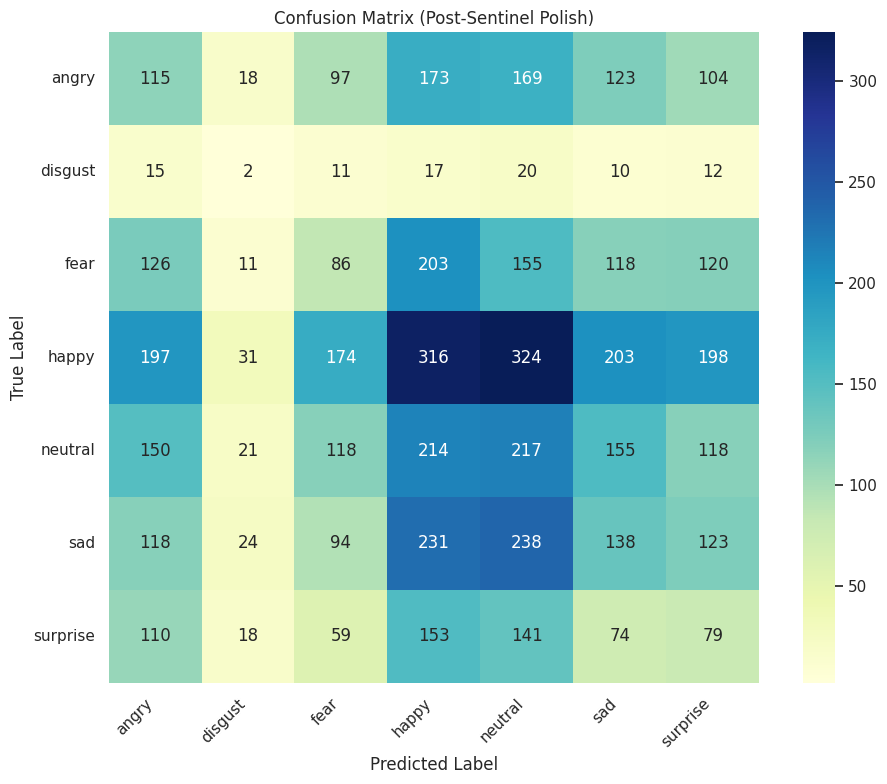

In [12]:
# Confusion Matrix (Post-Sentinel)
plot_confusion_matrix(validation_generator, model, 
                      "Confusion Matrix (Post-Sentinel Polish)", 
                      '/kaggle/working/confusion_matrix_sentinel.png')

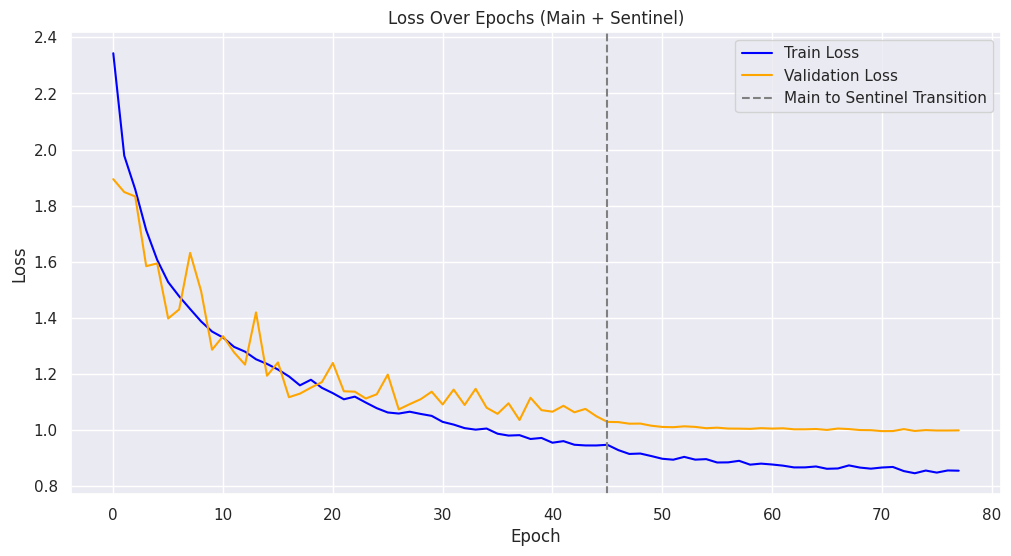

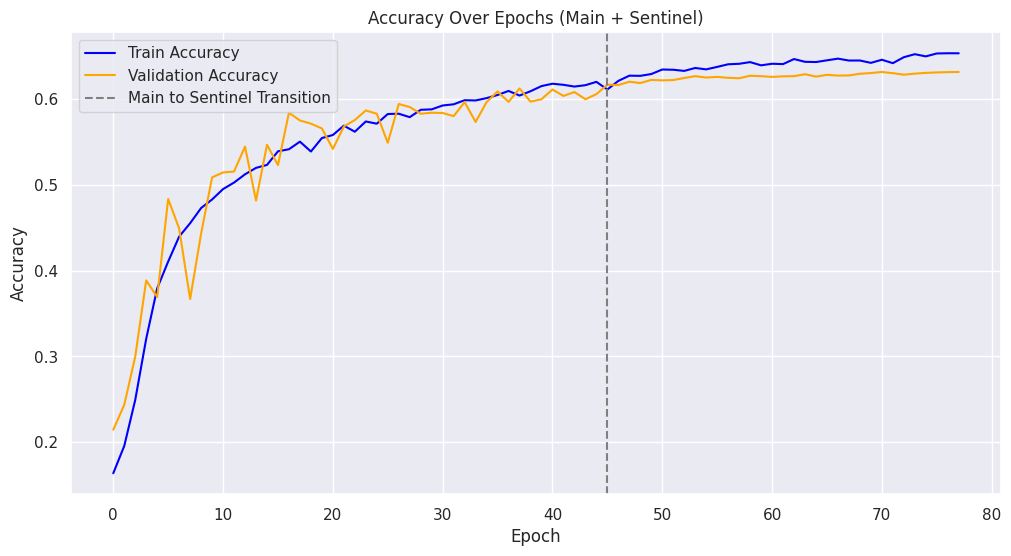

Plots saved as 'loss_plot.png' and 'accuracy_plot.png' in /kaggle/working/


In [13]:
# Visualization: Combined Main + Sentinel Progress
main_epochs = main_epoch_count  # Use actual main epochs
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Train Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
if len(history_dict['loss']) > main_epochs:
    plt.axvline(x=main_epochs, color='gray', linestyle='--', label='Main to Sentinel Transition')
plt.legend()
plt.title("Loss Over Epochs (Main + Sentinel)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
if len(history_dict['accuracy']) > main_epochs:
    plt.axvline(x=main_epochs, color='gray', linestyle='--', label='Main to Sentinel Transition')
plt.legend()
plt.title("Accuracy Over Epochs (Main + Sentinel)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Fallback: Save to files
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Train Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
if len(history_dict['loss']) > main_epochs:
    plt.axvline(x=main_epochs, color='gray', linestyle='--', label='Main to Sentinel Transition')
plt.legend()
plt.title("Loss Over Epochs (Main + Sentinel)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig('/kaggle/working/loss_plot.png')
plt.close()

plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
if len(history_dict['accuracy']) > main_epochs:
    plt.axvline(x=main_epochs, color='gray', linestyle='--', label='Main to Sentinel Transition')
plt.legend()
plt.title("Accuracy Over Epochs (Main + Sentinel)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig('/kaggle/working/accuracy_plot.png')
plt.close()

print("Plots saved as 'loss_plot.png' and 'accuracy_plot.png' in /kaggle/working/")

Processing images in folder: /kaggle/input/mytestimages/
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


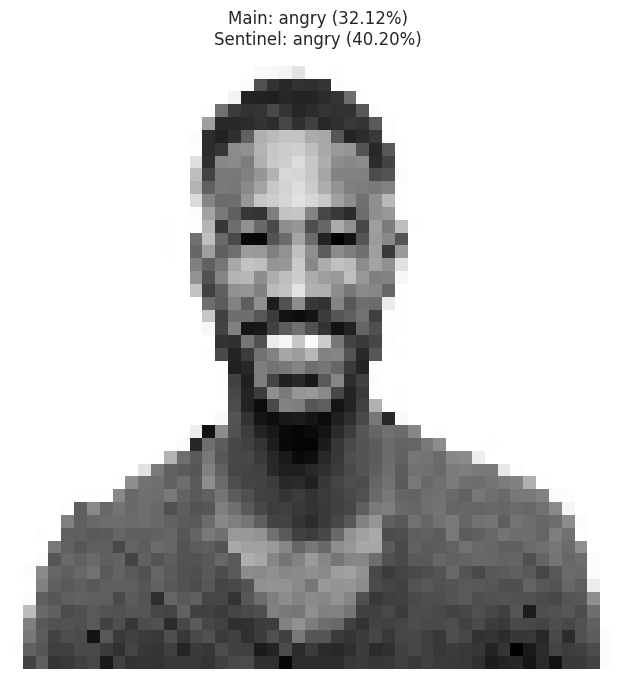

Image: image2.jpg
Main Prediction: angry (32.12%)
Sentinel Prediction: angry (40.20%)
Saved to: /kaggle/working/pred__image2.jpg
--------------------------------------------------


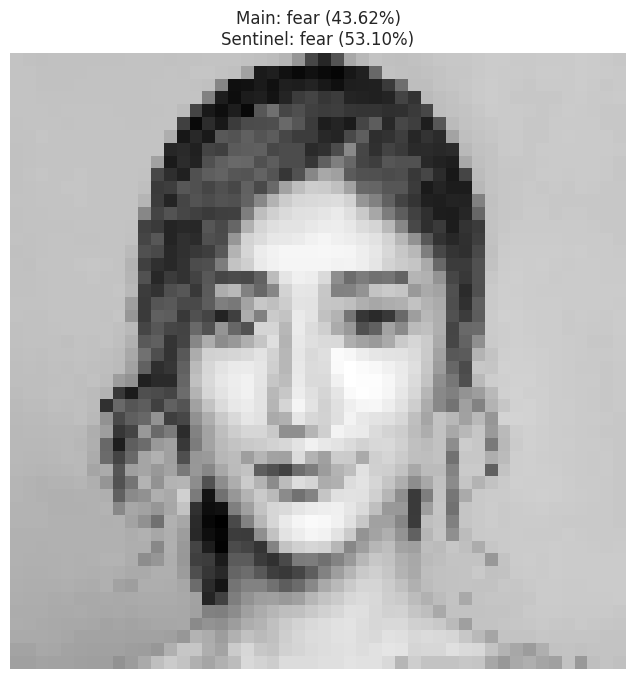

Image: image1.jpg
Main Prediction: fear (43.62%)
Sentinel Prediction: fear (53.10%)
Saved to: /kaggle/working/pred__image1.jpg
--------------------------------------------------


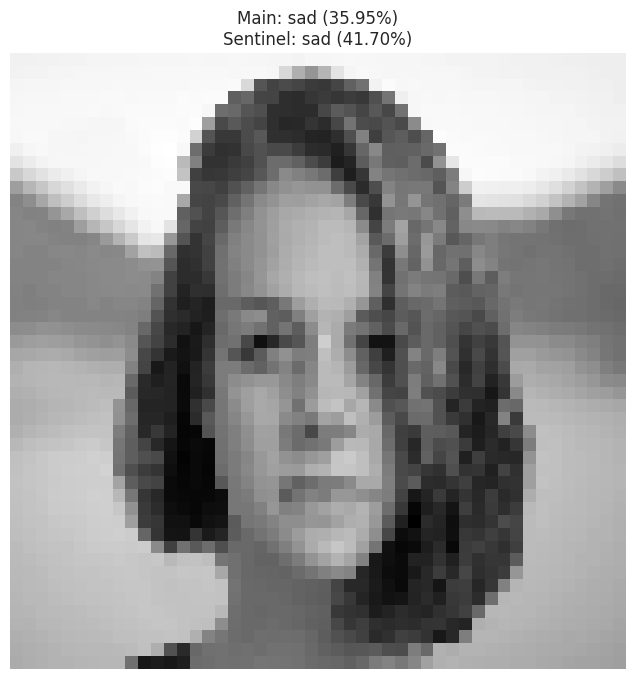

Image: image3.jpg
Main Prediction: sad (35.95%)
Sentinel Prediction: sad (41.70%)
Saved to: /kaggle/working/pred__image3.jpg
--------------------------------------------------


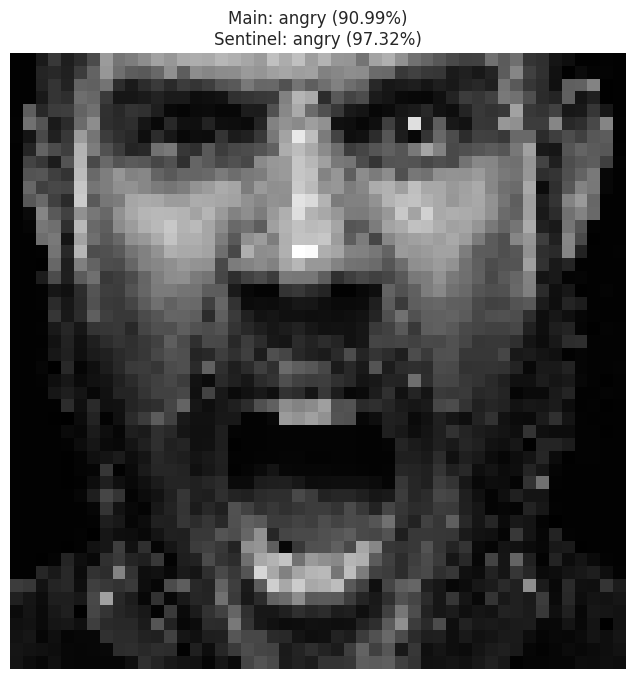

Image: image4.jpg
Main Prediction: angry (90.99%)
Sentinel Prediction: angry (97.32%)
Saved to: /kaggle/working/pred__image4.jpg
--------------------------------------------------
Processing images in folder: /kaggle/input/personal/
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


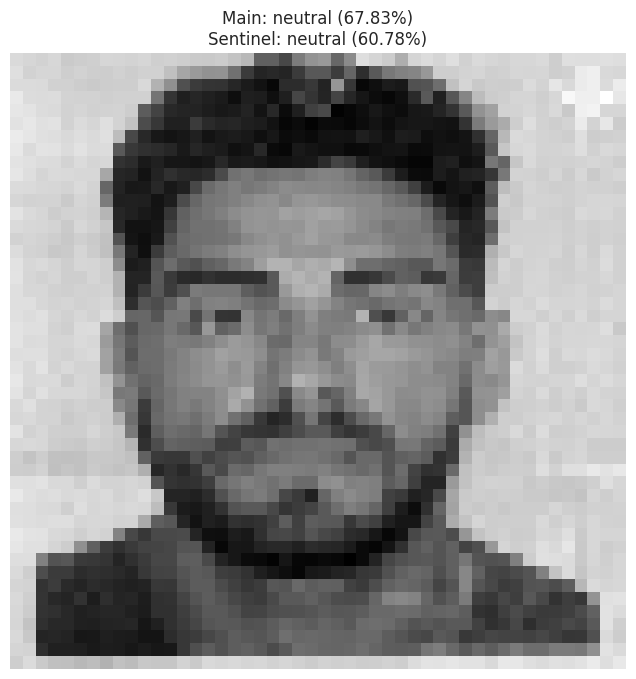

Image: yellow.jpg
Main Prediction: neutral (67.83%)
Sentinel Prediction: neutral (60.78%)
Saved to: /kaggle/working/pred__yellow.jpg
--------------------------------------------------


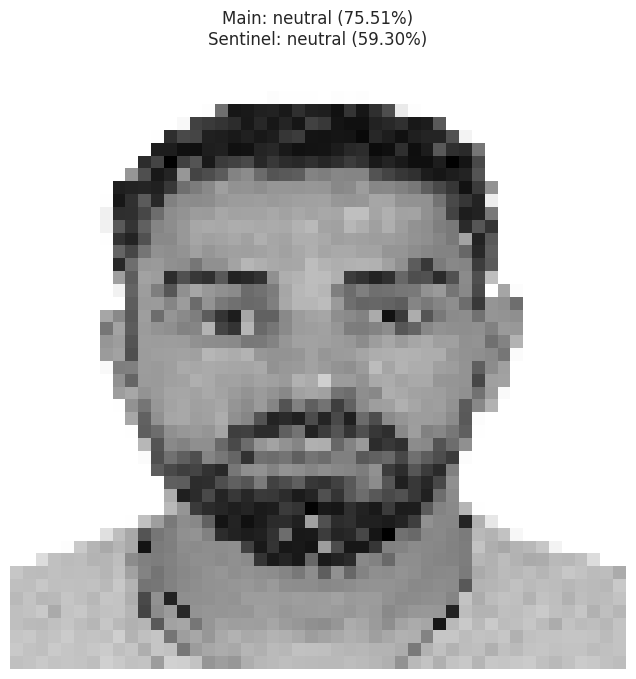

Image: latestpassport.jpg
Main Prediction: neutral (75.51%)
Sentinel Prediction: neutral (59.30%)
Saved to: /kaggle/working/pred__latestpassport.jpg
--------------------------------------------------


In [14]:
# CUSTOM IMAGE ANALYSIS 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def analyze_photos(model, main_weights_path, sentinel_weights_path, folder_paths, class_names):
    for folder_path in folder_paths:
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if not image_files:
            print(f"No images found in {folder_path}. Skipping this folder.")
            continue
        print(f"Processing images in folder: {folder_path}")
        print("-" * 50)
        images = []
        image_paths = []
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                img = image.load_img(image_path, target_size=(48, 48), color_mode="grayscale")
                img_array = image.img_to_array(img) / 255.0
                images.append(img_array)
                image_paths.append(image_path)
            except Exception as e:
                print(f"Error loading {image_file}: {str(e)}")
                continue
        if not images:
            print("No valid images to process in this folder.")
            continue
        img_batch = np.stack(images, axis=0)
        model.load_weights(main_weights_path)
        main_pred_probs = model.predict(img_batch)
        main_pred_labels = np.argmax(main_pred_probs, axis=1)
        main_confidences = np.max(main_pred_probs, axis=1) * 100
        model.load_weights(sentinel_weights_path)
        sentinel_pred_probs = model.predict(img_batch)
        sentinel_pred_labels = np.argmax(sentinel_pred_probs, axis=1)
        sentinel_confidences = np.max(sentinel_pred_probs, axis=1) * 100
        for i, (image_file, img) in enumerate(zip(image_files, images)):
            plt.figure(figsize=(8, 8))
            plt.imshow(img.squeeze(), cmap="gray")
            plt.axis("off")
            main_emotion = class_names[main_pred_labels[i]]
            sentinel_emotion = class_names[sentinel_pred_labels[i]]
            title = (f"Main: {main_emotion} ({main_confidences[i]:.2f}%)\n"
                     f"Sentinel: {sentinel_emotion} ({sentinel_confidences[i]:.2f}%)")
            plt.title(title, fontsize=12)
            save_path = f"/kaggle/working/pred_{os.path.basename(folder_path)}_{image_file}"
            plt.savefig(save_path)
            plt.show()
            print(f"Image: {image_file}")
            print(f"Main Prediction: {main_emotion} ({main_confidences[i]:.2f}%)")
            print(f"Sentinel Prediction: {sentinel_emotion} ({sentinel_confidences[i]:.2f}%)")
            print(f"Saved to: {save_path}")
            print("-" * 50)

folder_path_1 = "/kaggle/input/mytestimages/"
folder_path_2 = "/kaggle/input/personal/"
folder_paths = [folder_path_1, folder_path_2]
analyze_photos(model, main_weights_path, weights_path, folder_paths, class_names)